In [1]:
#!/usr/bin/env python
# coding: utf-8

# Temperature Prediction System with Time Series Analysis and Machine Learning
#### Can İpek

The data used in this project include hourly weather data since  January 1994 in Basel/Switzerland.

#### Importing and Previewing the Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

In [3]:
df = pd.read_excel('/kaggle/input/basel-temp-data/Basel Temp Data.xlsx')

In [4]:
df.head()

timestamp  Temperature  Precipitation Total  Wind Speed  \
0 1994-01-01 00:00:00     7.170245                  1.0   10.948973   
1 1994-01-01 01:00:00     6.840245                  0.6    9.339208   
2 1994-01-01 02:00:00     6.980245                  1.1    6.489992   
3 1994-01-01 03:00:00     6.110245                  2.2    7.235910   
4 1994-01-01 04:00:00     4.990245                  2.3   13.684735   

   Wind Direction  Cloud Cover Total  Sunshine Duration  \
0       207.40758               99.0                0.0   
1       207.55281               97.0                0.0   
2       213.69006               99.0                0.0   
3       264.28943              100.0                0.0   
4       296.56506              100.0                0.0   

   Mean Sea Level Pressure  Soil Temperature  Soil Moisture (Surface)  \
0                   1007.1              4.96                    0.435   
1                   1006.0              4.98                    0.434   
2                   1005.1              5.00                    0.437   
3                   1005.3              5.02                    0.437   
4                   1006.0              5.03                    0.437   

   Soil Moisture (Deeper)  
0                   0.402  
1                   0.403  
2                   0.403  
3                   0.404  
4                   0.406

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270337 entries, 0 to 270336
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   timestamp                270337 non-null  datetime64[ns]
 1   Temperature              270337 non-null  float64       
 2   Precipitation Total      270337 non-null  float64       
 3   Wind Speed               270337 non-null  float64       
 4   Wind Direction           270337 non-null  float64       
 5   Cloud Cover Total        270337 non-null  float64       
 6   Sunshine Duration        270337 non-null  float64       
 7   Mean Sea Level Pressure  270337 non-null  float64       
 8   Soil Temperature         270337 non-null  float64       
 9   Soil Moisture (Surface)  270337 non-null  float64       
 10  Soil Moisture (Deeper)   270337 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 22.7 MB


In [6]:
df.isnull().sum()

timestamp                  0
Temperature                0
Precipitation Total        0
Wind Speed                 0
Wind Direction             0
Cloud Cover Total          0
Sunshine Duration          0
Mean Sea Level Pressure    0
Soil Temperature           0
Soil Moisture (Surface)    0
Soil Moisture (Deeper)     0
dtype: int64

## Feature Engineering

In [7]:
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

In [8]:
df['season'] = df['month'].apply(lambda x: 'spring' if x >= 3 and x < 6
                                 else 'summer' if x >= 6 and x < 9
                                 else 'fall' if x >= 9 and x < 12
                                 else 'winter')

In [9]:
df.groupby(['season'])['Temperature'].mean()

season
fall      11.256647
spring    10.847170
summer    19.909024
winter     3.194736
Name: Temperature, dtype: float64

In [10]:
df = pd.merge(df, df.groupby(['month'])[['Temperature']].mean().reset_index(), on = 'month', how = 'left', suffixes = ["", "_month"])

In [11]:
df['season_temp'] = df['month'].apply(lambda x: 2 if x >= 3 and x < 6
                                 else 3 if x >= 6 and x < 9
                                 else 2 if x >= 9 and x < 12
                                 else 1)

In [12]:
df['Wind Card. Direction'] = df['Wind Direction'].apply(lambda x: 'NNE' if 11.25 <= x < 33.75
    else 'NE' if 33.75 <= x < 56.25
    else 'ENE' if 56.25 <= x < 78.75
    else 'E' if 78.75 <= x < 101.25
    else 'ESE' if 101.25 <= x < 123.75
    else 'SE' if 123.75 <= x < 146.25
    else 'SSE' if 146.25 <= x < 168.75
    else 'S' if 168.75 <= x < 191.25
    else 'SSW' if 191.25 <= x < 213.75
    else 'SW' if 213.75 <= x < 236.25
    else 'WSW' if 236.25 <= x < 258.75
    else 'W' if 258.75 <= x < 281.25
    else 'WNW' if 281.25 <= x < 303.75
    else 'NW' if 303.75 <= x < 326.25
    else 'NNW' if 326.25 <= x < 348.75
    else 'N')

In [13]:


df.groupby(['Wind Card. Direction'])['Wind Speed'].mean()

Wind Card. Direction
E       4.255851
ENE     5.634162
ESE     4.157666
N       7.784863
NE      7.378774
NNE     7.657890
NNW     6.427657
NW      6.467436
S       5.892994
SE      4.831038
SSE     5.331628
SSW     7.587669
SW     11.233116
W       9.259393
WNW     7.086547
WSW    10.948285
Name: Wind Speed, dtype: float64

In [14]:


df_wind_eff = df.groupby(['Wind Card. Direction'])[['Temperature']].mean().reset_index()

In [15]:


df_wind_eff.head()

Wind Card. Direction  Temperature
0                    E    10.217460
1                  ENE    10.723282
2                  ESE     9.587320
3                    N    12.824937
4                   NE    10.987795

In [16]:


df = pd.merge(df, df_wind_eff, on = 'Wind Card. Direction', how = 'left', suffixes = ["", "_Direction"])

In [17]:


df_yesterday = df[['timestamp', 'Temperature']].copy()
df_yesterday['timestamp'] = df['timestamp'] - pd.Timedelta(days=1)
df = pd.merge(df, df_yesterday, on = ['timestamp'], how = 'left', suffixes = ["", "_yesterday"])

## Exploratory Data Analysis

In [18]:


df.columns

Index(['timestamp', 'Temperature', 'Precipitation Total', 'Wind Speed',
       'Wind Direction', 'Cloud Cover Total', 'Sunshine Duration',
       'Mean Sea Level Pressure', 'Soil Temperature',
       'Soil Moisture (Surface)', 'Soil Moisture (Deeper)', 'date', 'time',
       'month', 'year', 'season', 'Temperature_month', 'season_temp',
       'Wind Card. Direction', 'Temperature_Direction',
       'Temperature_yesterday'],
      dtype='object')

In [19]:


df_numeric_only = df[['Temperature', 'Precipitation Total', 'Wind Speed', 'Cloud Cover Total', 'Sunshine Duration',
       'Mean Sea Level Pressure', 'Soil Temperature',
       'Soil Moisture (Surface)', 'Soil Moisture (Deeper)', 'Temperature_month', 'season_temp', 'Temperature_Direction',
       'Temperature_yesterday']]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

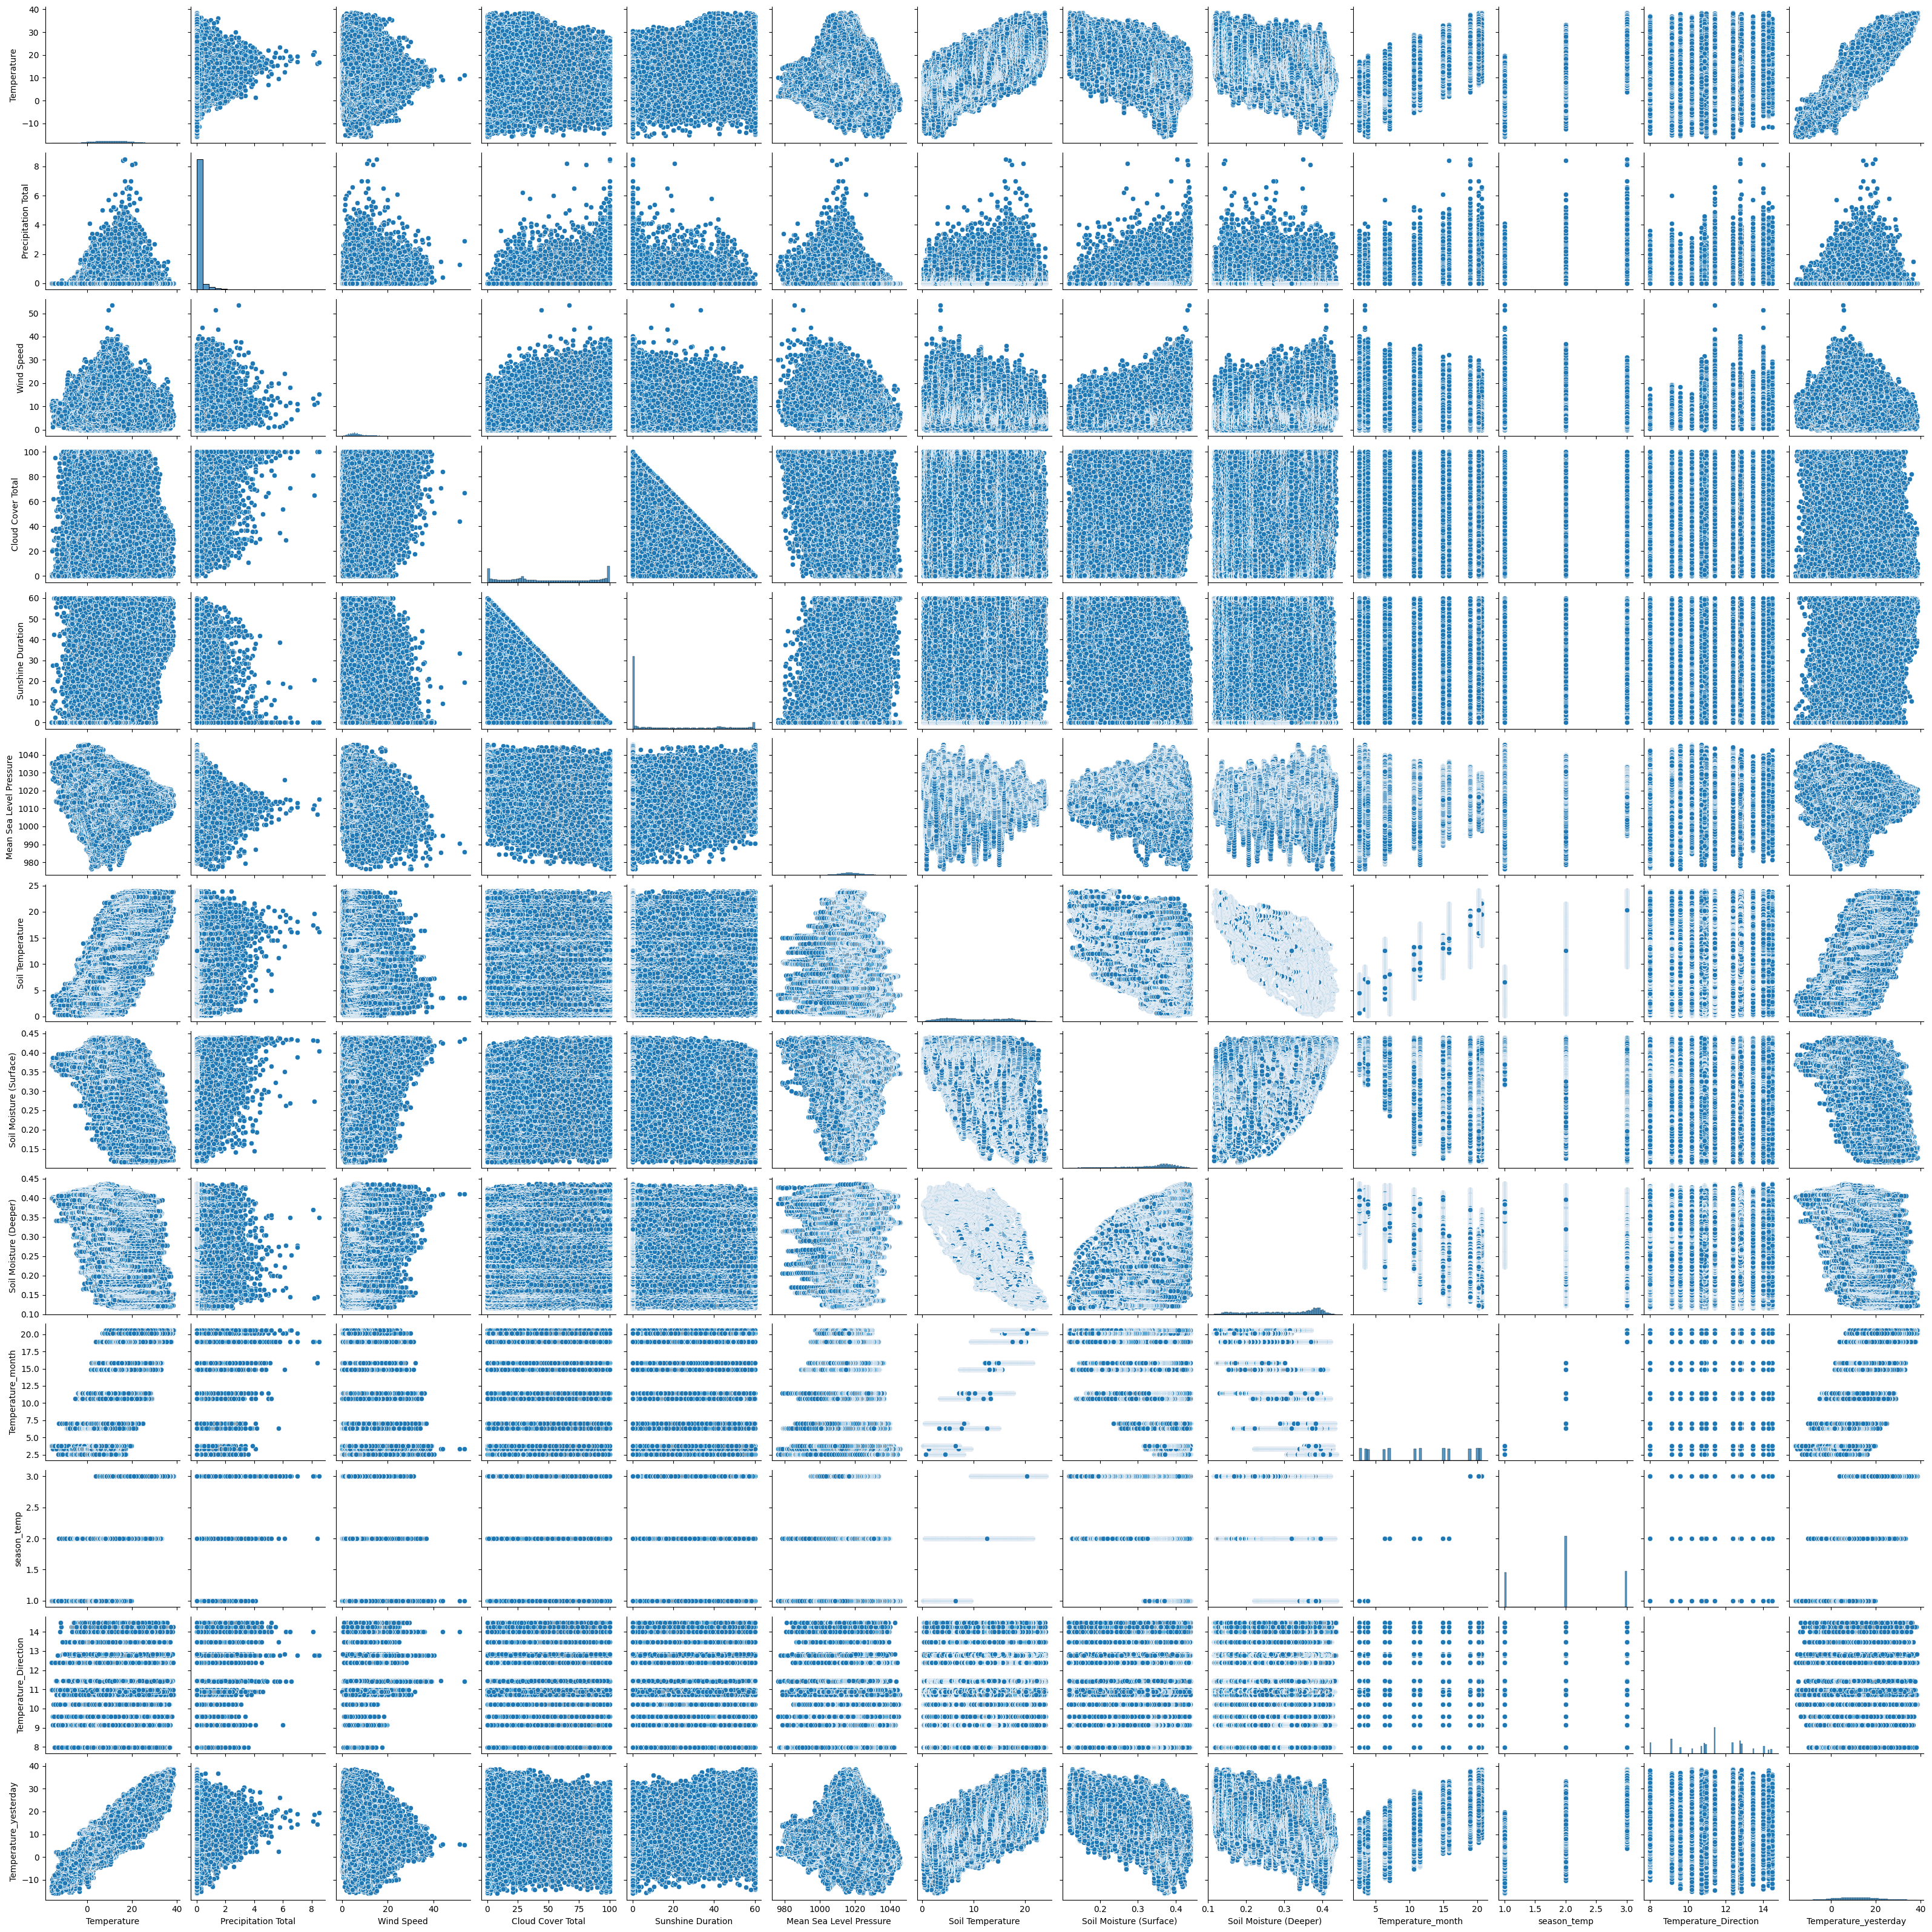

In [20]:


sns.pairplot(df_numeric_only, diag_kind="hist")
plt.show()

<Axes: >

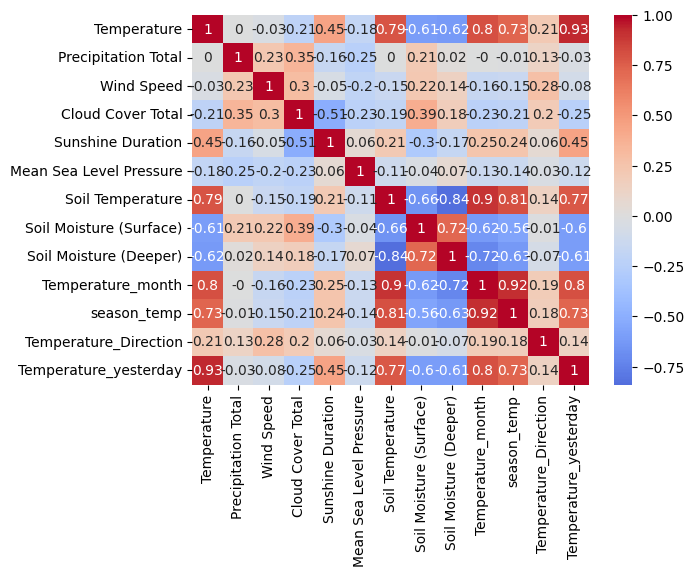

In [21]:


sns.heatmap(round(df_numeric_only.corr(),2), annot=True, cmap="coolwarm", center=0)

In [22]:


df.describe().T

count                           mean  \
timestamp                  270337  2009-06-03 00:00:00.000000256   
Temperature              270337.0                      11.363309   
Precipitation Total      270337.0                       0.104341   
Wind Speed               270337.0                       7.350789   
Wind Direction           270337.0                     170.812349   
Cloud Cover Total        270337.0                      48.587514   
Sunshine Duration        270337.0                        15.8268   
Mean Sea Level Pressure  270337.0                    1017.373455   
Soil Temperature         270337.0                      10.592848   
Soil Moisture (Surface)  270337.0                       0.334021   
Soil Moisture (Deeper)   270337.0                       0.303927   
month                    270337.0                       6.496643   
year                     270337.0                    2008.922197   
Temperature_month        270337.0                      11.363309   
season_temp              270337.0                       2.007546   
Temperature_Direction    270337.0                      11.363309   
Temperature_yesterday    270313.0                      11.363931   

                                         min                  25%  \
timestamp                1994-01-01 00:00:00  2001-09-17 00:00:00   
Temperature                       -15.959755             5.310245   
Precipitation Total                      0.0                  0.0   
Wind Speed                               0.0             4.334974   
Wind Direction                      1.080933             93.01279   
Cloud Cover Total                        0.0            18.300001   
Sunshine Duration                        0.0                  0.0   
Mean Sea Level Pressure                976.3               1012.7   
Soil Temperature                        0.23                 5.42   
Soil Moisture (Surface)                0.117                0.298   
Soil Moisture (Deeper)                 0.116                 0.23   
month                                    1.0                  4.0   
year                                  1994.0               2001.0   
Temperature_month                   2.547474             6.312347   
season_temp                              1.0                  2.0   
Temperature_Direction               7.992504             10.21746   
Temperature_yesterday             -15.959755             5.310245   

                                         50%                  75%  \
timestamp                2009-06-03 00:00:00  2017-02-17 00:00:00   
Temperature                        11.130245            17.040245   
Precipitation Total                      0.0                  0.0   
Wind Speed                          6.130579             9.028754   
Wind Direction                     174.80557            239.03624   
Cloud Cover Total                       43.0                 84.0   
Sunshine Duration                   0.606061            33.939392   
Mean Sea Level Pressure               1017.4               1022.4   
Soil Temperature                       10.37                 15.7   
Soil Moisture (Surface)                0.357                0.384   
Soil Moisture (Deeper)                 0.327                0.381   
month                                    7.0                  9.0   
year                                  2009.0               2017.0   
Temperature_month                  11.483646            18.907648   
season_temp                              2.0                  3.0   
Temperature_Direction              11.429396            12.780361   
Temperature_yesterday              11.140245            17.040245   

                                         max        std  
timestamp                2024-11-03 00:00:00        NaN  
Temperature                        38.570248   8.074573  
Precipitation Total                      8.5    0.31738  
Wind Speed                          53.41847   4.650754  
Wind Direction             

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Temperature', ylabel='Count'>

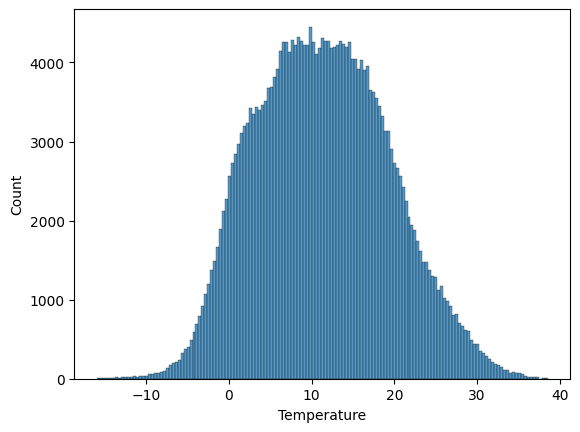

In [23]:


sns.histplot(df['Temperature'])

<Axes: xlabel='season', ylabel='Temperature'>

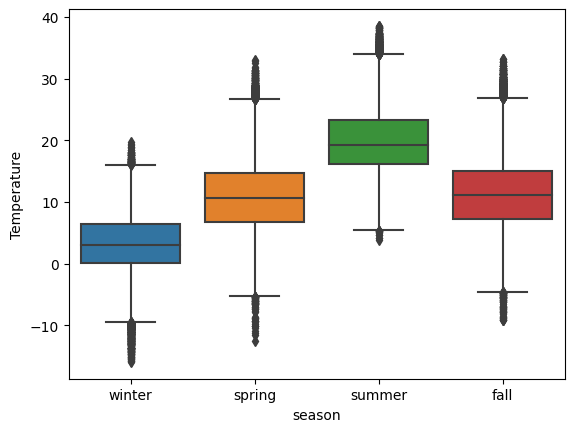

In [24]:


sns.boxplot(data = df, x = 'season', y = 'Temperature')

<Axes: xlabel='month', ylabel='Temperature'>

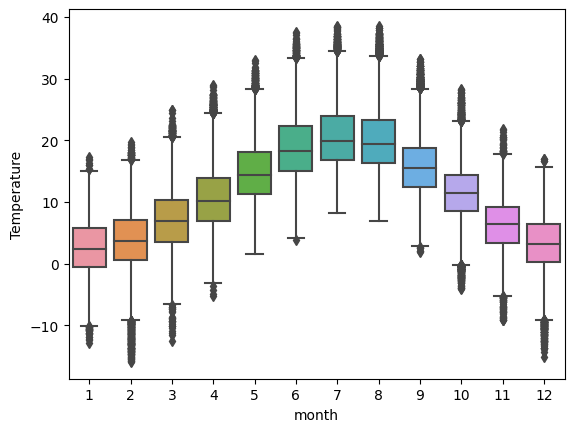

In [25]:


sns.boxplot(data = df, x = 'month', y = 'Temperature')

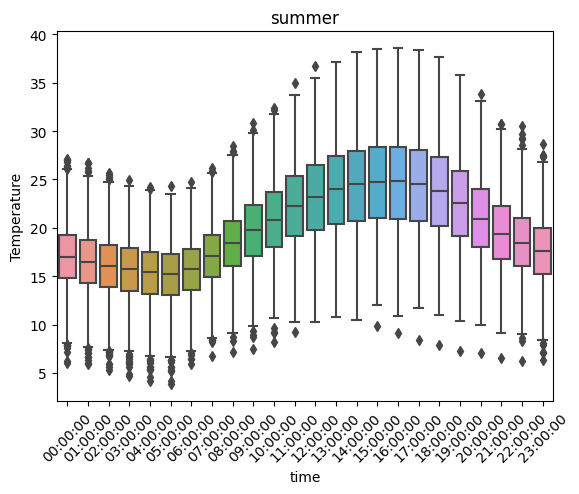

In [26]:


sns.boxplot(data = df[df['season'] == 'summer'], x = 'time', y = 'Temperature')
plt.title('summer')
plt.xticks(rotation = 45)
plt.show()

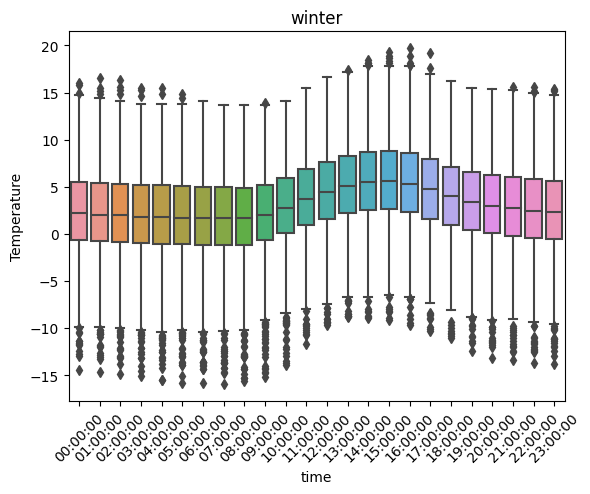

In [27]:


sns.boxplot(data = df[df['season'] == 'winter'], x = 'time', y = 'Temperature')
plt.title('winter')
plt.xticks(rotation = 45)
plt.show()

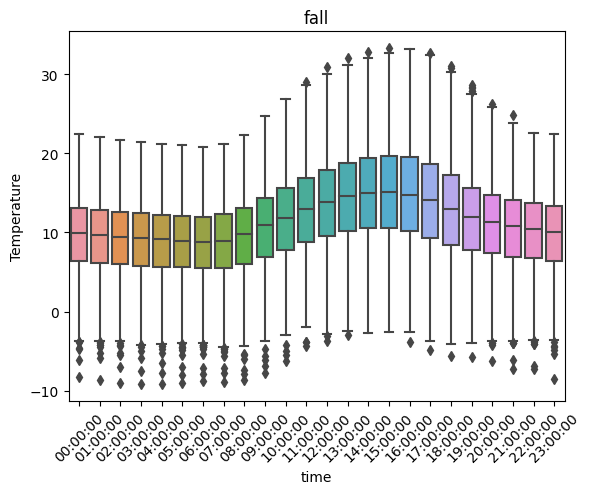

In [28]:


sns.boxplot(data = df[df['season'] == 'fall'], x = 'time', y = 'Temperature')
plt.title('fall')
plt.xticks(rotation = 45)
plt.show()

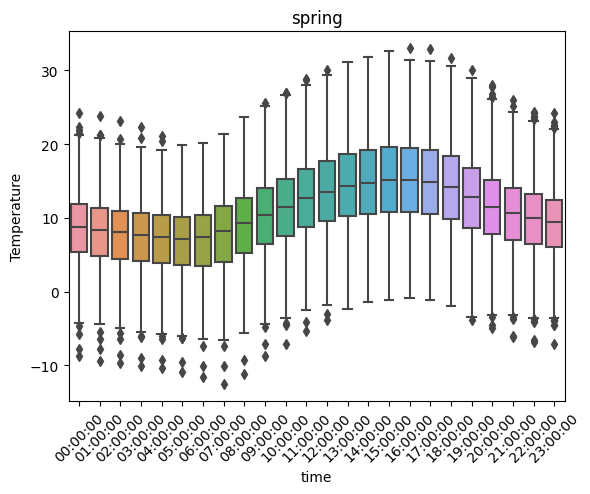

In [29]:


sns.boxplot(data = df[df['season'] == 'spring'], x = 'time', y = 'Temperature')
plt.title('spring')
plt.xticks(rotation = 45)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='year', ylabel='Temperature'>

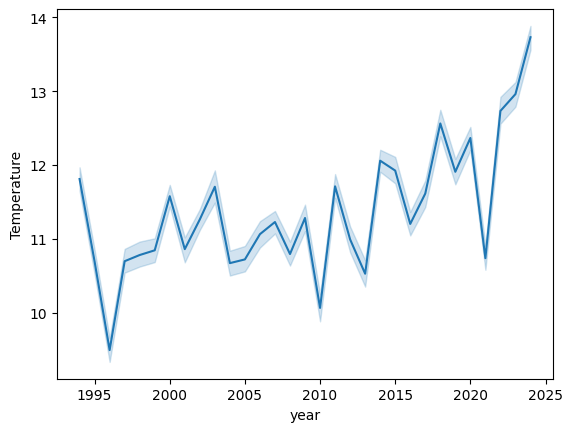

In [30]:


sns.lineplot(data = df, x = 'year', y = 'Temperature')

## Time Series Analysis

In [31]:


temperature_series = df.set_index('timestamp')
temperature_series = temperature_series['Temperature']
#temperature_series.index = pd.to_datetime(temperature_series.index)

In [32]:


temperature_series.head()

timestamp
1994-01-01 00:00:00    7.170245
1994-01-01 01:00:00    6.840245
1994-01-01 02:00:00    6.980245
1994-01-01 03:00:00    6.110245
1994-01-01 04:00:00    4.990245
Name: Temperature, dtype: float64

### Augmented Dickey-Fuller (ADF) Test for Stationarity Check

In [33]:


from statsmodels.tsa.stattools import adfuller

result = adfuller(temperature_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] < 0.05:
    print("Null hypothesis rejected. The Time Series is Stationary.")
else:
    print("Null hypothesis cannot be rejected. The Time Series is not Stationary.")

ADF Statistic: -13.660887386689534
p-value: 1.5222269644769211e-25
Null hypothesis rejected. The Time Series is Stationary.


### Seasonality

In [34]:


from statsmodels.tsa.seasonal import seasonal_decompose

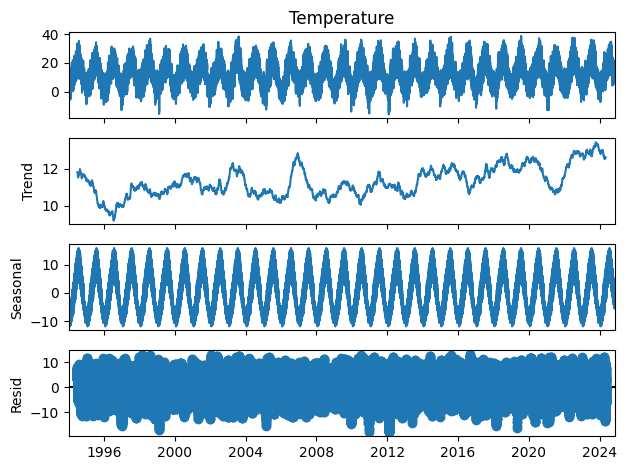

In [35]:


result_yearly = seasonal_decompose(temperature_series, period=365*24)
result_yearly.plot()
plt.show()

In [36]:


temperature_series

timestamp
1994-01-01 00:00:00    7.170245
1994-01-01 01:00:00    6.840245
1994-01-01 02:00:00    6.980245
1994-01-01 03:00:00    6.110245
1994-01-01 04:00:00    4.990245
                         ...   
2024-11-02 20:00:00    9.080245
2024-11-02 21:00:00    8.320246
2024-11-02 22:00:00    7.860245
2024-11-02 23:00:00    8.090245
2024-11-03 00:00:00    8.130245
Name: Temperature, Length: 270337, dtype: float64

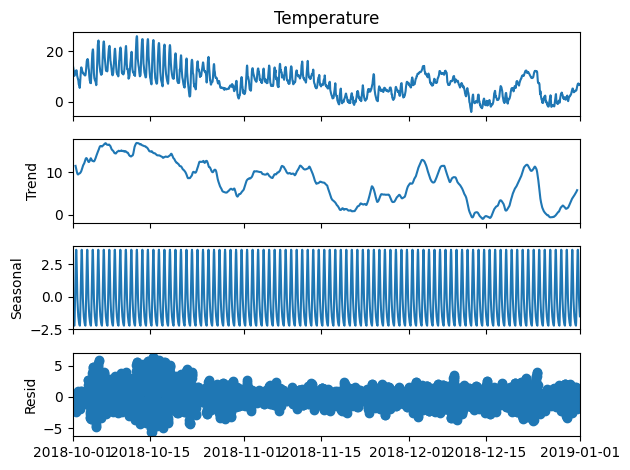

In [37]:


result = seasonal_decompose(temperature_series['2018-10-01 00:00:00':'2019-01-01 00:00:00'], period=24)
result.plot()
plt.show()

### Handling Seasonality

In [38]:


from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(temperature_series, model='additive', period=24*365)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

In [39]:


annualy_deseasonalized_data = temperature_series - seasonal

In [40]:


decompose_result = seasonal_decompose(annualy_deseasonalized_data, model='additive', period=24)
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

In [41]:


daily_deseasonalized_data = annualy_deseasonalized_data - seasonal

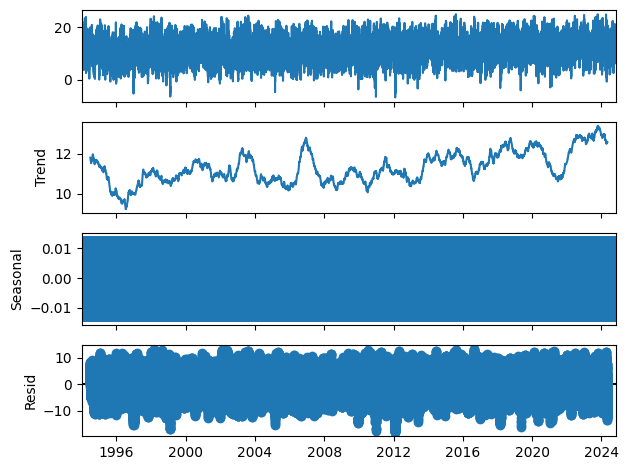

In [42]:


result_yearly = seasonal_decompose(daily_deseasonalized_data, period=365*24)
result_yearly.plot()
plt.show()

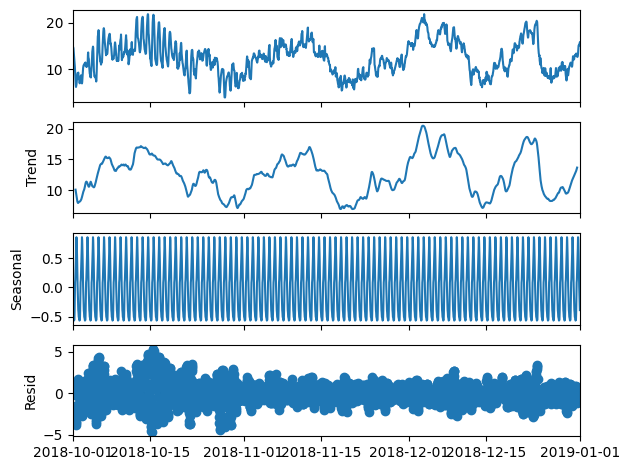

In [43]:


result = seasonal_decompose(daily_deseasonalized_data['2018-10-01 00:00:00':'2019-01-01 00:00:00'], period=24)
result.plot()
plt.show()

##### Add series to Data

In [44]:


df = df.set_index('timestamp')
df['temp_des'] = daily_deseasonalized_data

## Machine Learning

In [45]:


df.columns

Index(['Temperature', 'Precipitation Total', 'Wind Speed', 'Wind Direction',
       'Cloud Cover Total', 'Sunshine Duration', 'Mean Sea Level Pressure',
       'Soil Temperature', 'Soil Moisture (Surface)', 'Soil Moisture (Deeper)',
       'date', 'time', 'month', 'year', 'season', 'Temperature_month',
       'season_temp', 'Wind Card. Direction', 'Temperature_Direction',
       'Temperature_yesterday', 'temp_des'],
      dtype='object')

In [46]:


df_numeric_only = df[['Temperature', 'Precipitation Total', 'Wind Speed', 'Cloud Cover Total', 'Sunshine Duration',
       'Mean Sea Level Pressure', 'Soil Temperature',
       'Soil Moisture (Surface)', 'Soil Moisture (Deeper)', 'Temperature_month', 'season_temp', 'Temperature_Direction',
       'Temperature_yesterday', 'temp_des']]

<Axes: >

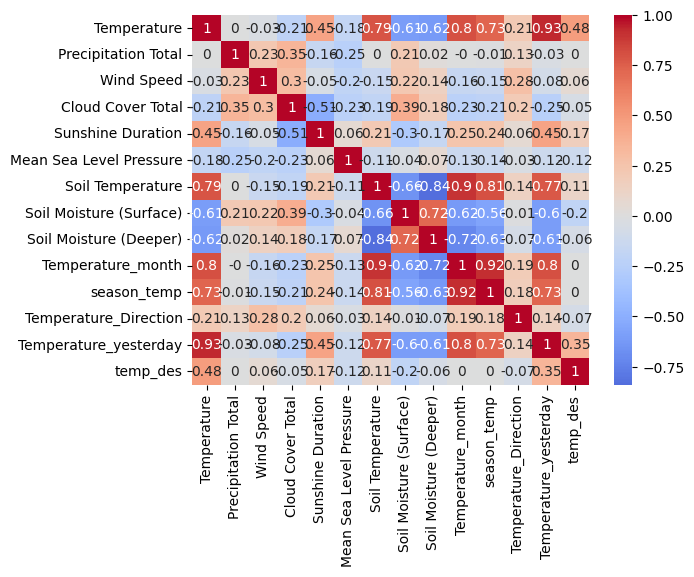

In [47]:


sns.heatmap(round(df_numeric_only.corr(),2), annot=True, cmap="coolwarm", center=0)

### Predicting Deseasonalized Variable

In [48]:


df.dropna(inplace = True)

In [49]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df_s = df.sample(20000)
X = df_s.drop(['Temperature',
#             'Precipitation Total',
#             'Wind Speed',
#             'Wind Direction',
#             'Cloud Cover Total',
#             'Sunshine Duration',
#             'Mean Sea Level Pressure',
#             'Soil Temperature', 'Soil Moisture (Surface)',
             'Soil Moisture (Deeper)',
             'date', 'time', 'month', 'year',
             'season',
#             'Temperature_month',
             'season_temp',
             'Wind Card. Direction',
#             'Temperature_Direction',
#             'Temperature_yesterday',
             'temp_des'],
                          axis=1)
y = df_s['temp_des']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [50]:


# Modeli tanımlama ve eğitme
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Tahminler
y_pred = lr_model.predict(X_test)

# Performans metriklerini hesaplama
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Sonuçları bastırma
print(f"Linear Regression Results:")
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Linear Regression Results:
R²: 0.3871214065740254
MSE: 9.615485036720903
RMSE: 3.1008845571418653
MAE: 2.458103019693047


#### Gradient Boosting

In [51]:


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [52]:


gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [53]:


gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.6073035628195749
MSE: 6.161035409271578
RMSE: 2.4821433095757337
MAE: 1.9462237903199981


#### Artificial Neural Networks

In [54]:


from sklearn.neural_network import MLPRegressor

# ANN hiperparametre ızgarası
ann_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01]
}

# Hiperparametre optimizasyonu
ann_grid = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), ann_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ann_grid.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'solver': ['adam', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [55]:


ann_grid.best_estimator_

MLPRegressor(max_iter=1000, random_state=42, solver='lbfgs')

In [56]:


# En iyi modelle tahmin yapma
ann_best_model = ann_grid.best_estimator_
y_pred_ann = ann_best_model.predict(X_test)

# Performans metriklerini hesaplama
r2_ann = r2_score(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)

# Sonuçları bastırma
print(f"Artificial Neural Network Results:")
print(f"Best Params: {ann_grid.best_params_}")
print(f"R²: {r2_ann}")
print(f"MSE: {mse_ann}")
print(f"RMSE: {rmse_ann}")
print(f"MAE: {mae_ann}")

Artificial Neural Network Results:
Best Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
R²: 0.45930119148985116
MSE: 8.48305253009317
RMSE: 2.912568030122759
MAE: 2.296464469814684


In [57]:


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Gradient Boosting hiperparametre ızgarası
gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}

# Hiperparametre optimizasyonu
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [58]:


gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [59]:


# En iyi modelle tahmin yapma
gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)

# Performans metriklerini hesaplama
r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

# Sonuçları bastırma
print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.6073035628195749
MSE: 6.161035409271578
RMSE: 2.4821433095757337
MAE: 1.9462237903199981


#### Random Forrest Regressor

In [60]:


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Random Forest hiperparametre ızgarası
rf_params = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

# Hiperparametre optimizasyonu
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [61]:


# En iyi modelle tahmin yapma
rf_best_model = rf_grid.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

# Performans metriklerini hesaplama
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Sonuçları bastırma
print(f"Random Forest Results:")
print(f"Best Params: {rf_grid.best_params_}")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")

Random Forest Results:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
R²: 0.6051831255340798
MSE: 6.194303063271382
RMSE: 2.4888356842651107
MAE: 1.92631867988996


### Predicting Main Variable

In [62]:


df.dropna(inplace = True)

In [63]:


df_s = df.sample(20000)
X = df_s.drop(['Temperature',
#             'Precipitation Total',
#             'Wind Speed',
#             'Wind Direction',
#             'Cloud Cover Total',
#             'Sunshine Duration',
#             'Mean Sea Level Pressure',
#             'Soil Temperature', 'Soil Moisture (Surface)',
             'Soil Moisture (Deeper)',
             'date', 'time', 'month', 'year',
             'season',
#             'Temperature_month',
             'season_temp',
             'Wind Card. Direction',
#             'Temperature_Direction',
#             'Temperature_yesterday',
             'temp_des'],
                          axis=1)
y = df_s['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [64]:


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression Results:")
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

Linear Regression Results:
R²: 0.9077164598103395
MSE: 6.245969396417868
RMSE: 2.4991937492755274
MAE: 1.919586180625033


#### Gradient Boosting

In [65]:


gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [66]:


gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [67]:


gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.9243953591268591
MSE: 5.1171018379907105
RMSE: 2.262101199767754
MAE: 1.7373119296813453


#### Artificial Neural Networks

In [68]:


ann_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01]
}

ann_grid = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), ann_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ann_grid.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'solver': ['adam', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [69]:


ann_grid.best_estimator_

MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50), max_iter=1000,
             random_state=42, solver='lbfgs')

In [70]:


ann_best_model = ann_grid.best_estimator_
y_pred_ann = ann_best_model.predict(X_test)

r2_ann = r2_score(y_test, y_pred_ann)
mse_ann = mean_squared_error(y_test, y_pred_ann)
rmse_ann = np.sqrt(mse_ann)
mae_ann = mean_absolute_error(y_test, y_pred_ann)

print(f"Artificial Neural Network Results:")
print(f"Best Params: {ann_grid.best_params_}")
print(f"R²: {r2_ann}")
print(f"MSE: {mse_ann}")
print(f"RMSE: {rmse_ann}")
print(f"MAE: {mae_ann}")

Artificial Neural Network Results:
Best Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'solver': 'lbfgs'}
R²: 0.9056508265236685
MSE: 6.3857763681297675
RMSE: 2.5270093723866096
MAE: 1.9284143873811062


In [71]:


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

#Gradient Boosting hiperparametre ızgarası
gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}

# Hiperparametre optimizasyonu
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [72]:


gb_grid.best_estimator_

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [73]:


gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.9243953591268591
MSE: 5.1171018379907105
RMSE: 2.262101199767754
MAE: 1.7373119296813453


#### Random Forrest Regressor

In [74]:


rf_params = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [75]:


rf_best_model = rf_grid.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest Results:")
print(f"Best Params: {rf_grid.best_params_}")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")

Random Forest Results:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
R²: 0.9242302088189738
MSE: 5.128279603459407
RMSE: 2.2645705119203967
MAE: 1.7290013080234228


#### Fitting Check

In [76]:


gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_train)

r2_gb = r2_score(y_train, y_pred_gb)
mse_gb = mean_squared_error(y_train, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_train, y_pred_gb)

print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.9449234675487616
MSE: 3.5916303519257764
RMSE: 1.895159716732544
MAE: 1.4640013256539937


In [77]:


df_s = df.sample(20000)
X = df_s.drop(['Temperature',
#             'Precipitation Total',
#             'Wind Speed',
#             'Wind Direction',
#             'Cloud Cover Total',
#             'Sunshine Duration',
#             'Mean Sea Level Pressure',
#             'Soil Temperature', 'Soil Moisture (Surface)',
             'Soil Moisture (Deeper)',
             'date', 'time', 'month', 'year',
             'season',
#             'Temperature_month',
             'season_temp',
             'Wind Card. Direction',
#             'Temperature_Direction',
#             'Temperature_yesterday',
             'temp_des'],
                          axis=1)
y = df_s['temp_des']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:


gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [79]:


gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_train)

r2_gb = r2_score(y_train, y_pred_gb)
mse_gb = mean_squared_error(y_train, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_train, y_pred_gb)

print(f"Gradient Boosting Results:")
print(f"Best Params: {gb_grid.best_params_}")
print(f"R²: {r2_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

Gradient Boosting Results:
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
R²: 0.9735887366848098
MSE: 0.406078673700877
RMSE: 0.6372430256196431
MAE: 0.47223436825206305


In [80]:


X = df.drop(['Temperature',
#             'Precipitation Total',
#             'Wind Speed',
#             'Wind Direction',
#             'Cloud Cover Total',
#             'Sunshine Duration',
#             'Mean Sea Level Pressure',
#             'Soil Temperature', 'Soil Moisture (Surface)',
             'Soil Moisture (Deeper)',
             'date', 'time', 'month', 'year',
             'season',
#             'Temperature_month',
             'season_temp',
             'Wind Card. Direction',
#             'Temperature_Direction',
#             'Temperature_yesterday',
             'temp_des'],
                          axis=1)
y = df['temp_des']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_best_model = gb_grid.best_estimator_
y_pred_gb = gb_best_model.predict(X_train)

all_predictions = gb_best_model.predict(X)

df['d_pred'] = all_predictions

In [81]:


df['d_pred_norm'] = df['d_pred'] + seasonal

In [82]:


y_act = df['Temperature']
y_pred = df['d_pred_norm']

# Performans metriklerini hesaplama
r2 = r2_score(y_act, y_pred)
mse = mean_squared_error(y_act, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_act, y_pred)

# Sonuçları bastırma
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R²: 0.2035601142381357
MSE: 51.930592553509726
RMSE: 7.2062884034369405
MAE: 6.1916795483532265
